# EGO Facebook

In [2]:
import math, subprocess
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import networkx as nx

In [3]:
def metodo_de_la_potencia(matriz):
    return np.linalg.eig(matriz)

# Item 3.1
## Con los datos de Facebook, computar la matriz de similaridad con producto interno de la matriz de atributos

In [4]:
def calcular_matriz_similaridad(matriz: np.matrix) -> np.matrix:
    return np.dot(matriz, np.transpose(matriz))

In [5]:
# Levantamos la matriz de atributos
f = open("../tests/ego-facebook.feat", "r")
lineas = []
for linea in f:
    lineas.append([int(i) for i in linea.split(" ")])
nodes = [linea[0] for linea in lineas]
attributes = np.matrix([linea[1:] for linea in lineas])
matriz_similaridad = calcular_matriz_similaridad(attributes)
matriz_similaridad = matriz_similaridad / np.max(matriz_similaridad)

In [6]:
# Levantamos la matriz con los resultados de la realidad
f = open("../tests/ego-facebook.edges", "r")
resultados_esperados = np.zeros((len(nodes), len(nodes)))
for linea in f:
    desde, hasta = [int(i) for i in linea.split(" ")]
    resultados_esperados[nodes.index(desde), nodes.index(hasta)] = 1

In [7]:
# Calculamos el puntaje de la matriz contando la cantidad de correctos dividido el total de elementos
def calcular_puntaje(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(matriz == esperado) / (matriz.shape[0] * matriz.shape[1])

In [8]:
def falsos_positivos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 1, esperado == 0)) / (matriz.shape[0] * matriz.shape[1])

In [9]:
def falsos_negativos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 0, esperado == 1)) / (matriz.shape[0] * matriz.shape[1])

In [10]:
def verdaderos_positivos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 1, esperado == 1)) / (matriz.shape[0] * matriz.shape[1])

In [11]:
def verdaderos_negativos(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.sum(np.logical_and(matriz == 0, esperado == 0)) / (matriz.shape[0] * matriz.shape[1])

In [64]:
def puntaje_por_correlacion_matriz_adyacencia(matriz: np.matrix, esperado: np.matrix) -> float:
    return np.corrcoef(matriz.flatten(), esperado.flatten())[0,1]

In [73]:
def puntaje_por_correlacion_autovalores(matriz: np.matrix, esperado: np.matrix) -> float:
    autovalores_matriz, autovectores_matriz = metodo_de_la_potencia(matriz)
    autovalores_esperado, autovectores_esperado = metodo_de_la_potencia(esperado)
    return np.corrcoef(autovalores_matriz, autovalores_esperado)[0,1]

count    18.000000
mean      0.026287
std       0.039628
min      -0.003054
25%      -0.001913
50%      -0.000885
75%       0.051658
max       0.108301
dtype: float64
Mejor umbral: 0.25000000000000006


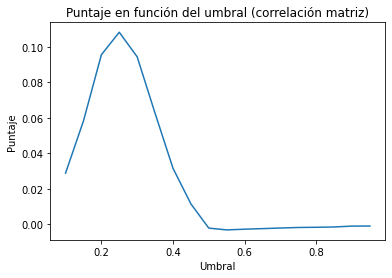

In [78]:
# Comparamos la matriz de similaridad con distintos umbrales contra los resultados reales
umbrales = np.arange(0.1, 1, 0.05)
puntajes = []
for umbral in umbrales:
    red = (matriz_similaridad > umbral).astype(int)
    puntajes.append(puntaje_por_correlacion_matriz_adyacencia(red, resultados_esperados))
print(pd.Series(puntajes).describe())
print('Mejor umbral:', umbrales[np.argmax(puntajes)])

plt.plot(umbrales, puntajes)
plt.xlabel("Umbral")
plt.ylabel("Puntaje")
plt.title("Puntaje en función del umbral (correlación matriz)")

plt.savefig('./graficos/puntaje-umbral-correlacion-matriz.png')
plt.show()
plt.close()

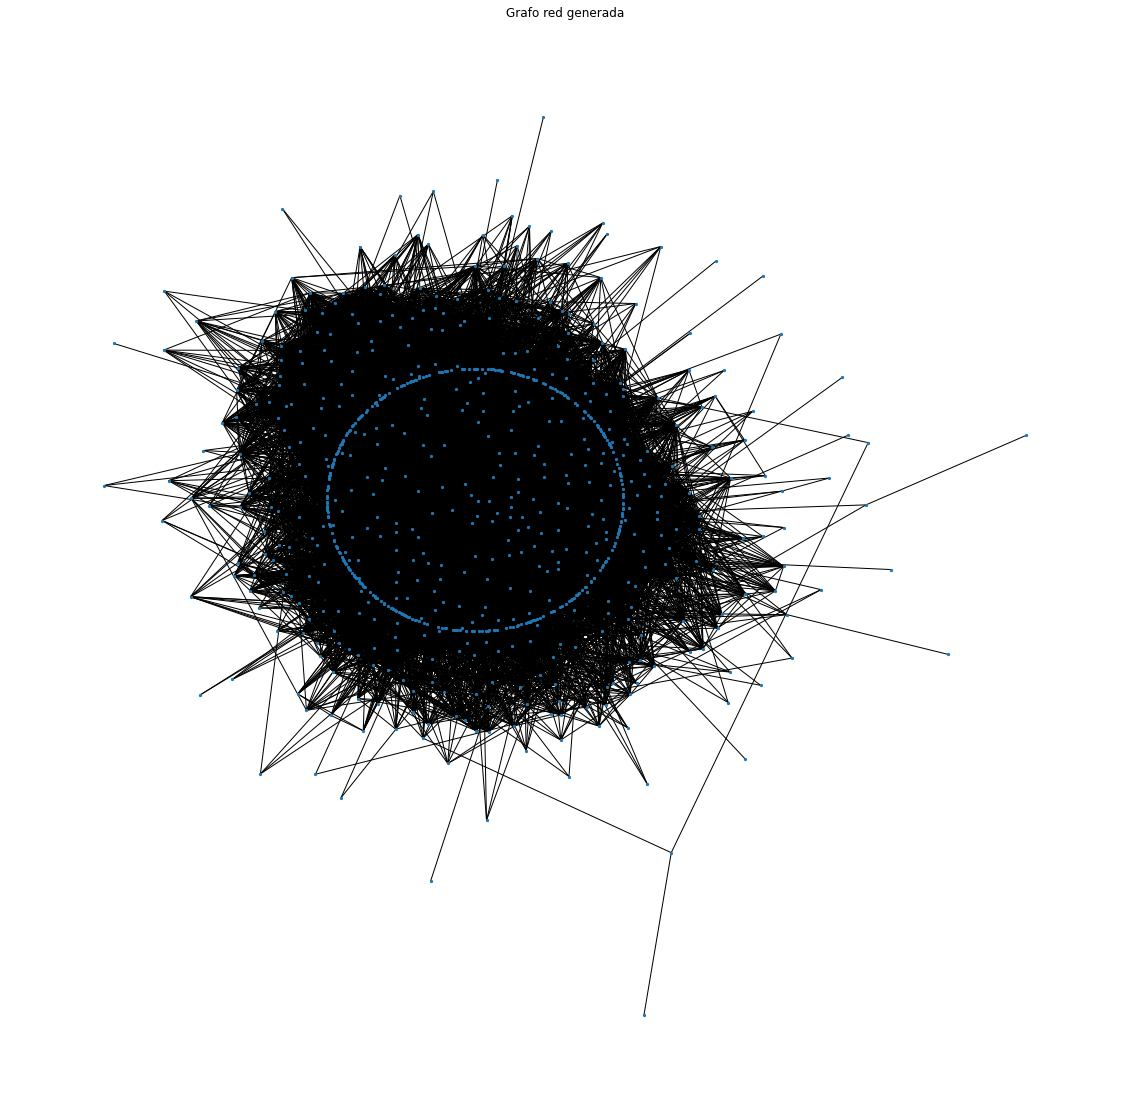

In [97]:
red_generada = (matriz_similaridad > 0.25).astype(int)
G = nx.Graph()
G.add_nodes_from(nodes)
for i in range(red_generada.shape[0]):
    for j in range(red_generada.shape[1]):
        if (red_generada[i, j] == 1 and i != j):
            G.add_edge(nodes[i], nodes[j])
plt.figure(4,figsize=(20,20))
ax = plt.gca()
ax.set_title('Grafo red generada')
nx.draw_networkx(G, pos=nx.layout.kamada_kawai_layout(G), node_size=5, ax=ax, with_labels=False)
_ = ax.axis('off')
plt.savefig('./graficos/grafo-red-estimada-fb.png')
plt.show()
plt.close()

## Aplicamos PCA

In [81]:
def calcular_matriz_covarianza(matriz: np.matrix) -> np.matrix:
    return np.dot(matriz.transpose(), matriz)

c:\python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


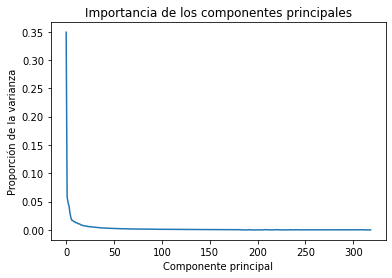

In [82]:
# Convertimos la media y varianza en cero
atributos_pca: np.matrix = attributes
atributos_pca = np.subtract(atributos_pca, atributos_pca.mean())
atributos_pca = np.divide(atributos_pca, atributos_pca.std())
matriz_covarianza = calcular_matriz_covarianza(atributos_pca)
autovalores, autovectores = metodo_de_la_potencia(matriz_covarianza)
# Factorizamos C = VDVt
D: np.matrix = np.diag(autovalores)
V: np.matrix = autovectores
# Analizamos los componentes principales
plt.plot([i for i in range(len(autovalores))], [i / sum(autovalores) for i in autovalores])
plt.xlabel("Componente principal")
plt.ylabel("Proporción de la varianza")
plt.title("Importancia de los componentes principales")
plt.savefig('./graficos/importancia-cp.png')
plt.show()
plt.close()

1 componentes principales
count    31.000000
mean      0.010129
std       0.004321
min      -0.001310
25%       0.007907
50%       0.012027
75%       0.013116
max       0.014937
dtype: float64
3 componentes principales
count    31.000000
mean      0.023184
std       0.016367
min      -0.001393
25%       0.011226
50%       0.021188
75%       0.034400
max       0.055282
dtype: float64


c:\python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


6 componentes principales
count    30.000000
mean      0.051758
std       0.032648
min       0.004853
25%       0.023066
50%       0.046452
75%       0.081432
max       0.103903
dtype: float64
25 componentes principales
count    31.000000
mean      0.030667
std       0.037555
min      -0.001593
25%      -0.000273
50%       0.009237
75%       0.058147
max       0.102971
dtype: float64
50 componentes principales
count    31.000000
mean      0.026179
std       0.037596
min      -0.002185
25%      -0.000939
50%       0.001258
75%       0.047342
max       0.107604
dtype: float64


c:\python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


100 componentes principales
count    30.000000
mean      0.025552
std       0.038316
min      -0.002759
25%      -0.001527
50%      -0.000667
75%       0.047387
max       0.107209
dtype: float64


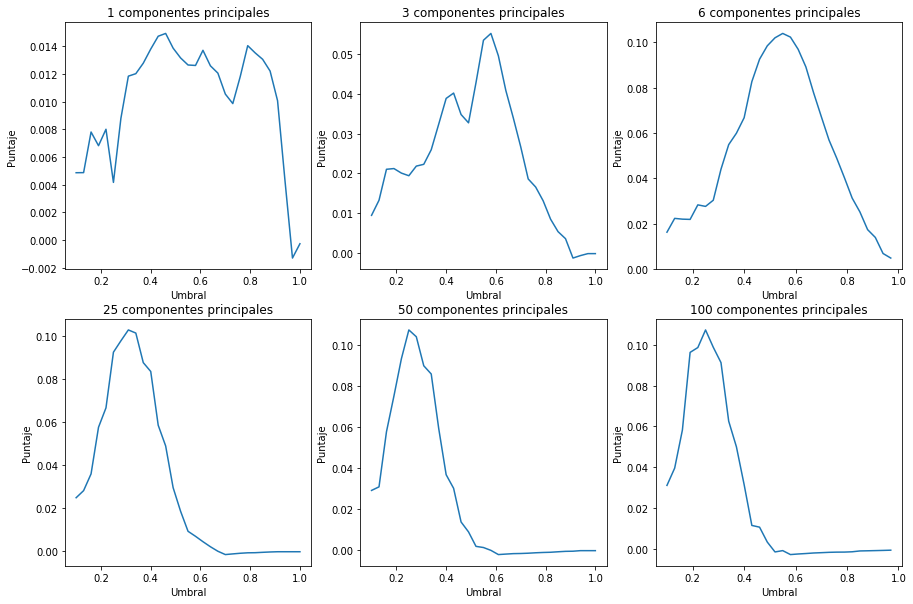

In [85]:
k_a_evaluar = [1, 3, 6, 25, 50, 100]
umbrales = np.arange(0.1, 1, 0.03)
fig, subplots = plt.subplots(2, 3, figsize = (15,10))
i = 0
for k in k_a_evaluar:
    # Generamos la nueva matriz de atributos
    nueva_matriz_atributos = np.dot(atributos_pca, V[:, :k])
    nueva_matriz_similaridad = calcular_matriz_similaridad(nueva_matriz_atributos)
    nueva_matriz_similaridad = nueva_matriz_similaridad / np.max(nueva_matriz_similaridad)
    # Calculamos los puntajes para cada umbral
    puntajes = []
    for umbral in umbrales:
        red = (nueva_matriz_similaridad > umbral).astype(int)
        puntajes.append(puntaje_por_correlacion_matriz_adyacencia(red, resultados_esperados))
    print(f'{k} componentes principales')
    print(pd.Series(puntajes).describe())
    subplots[int(i/3)][i%3].plot(umbrales, puntajes)
    subplots[int(i/3)][i%3].set_xlabel("Umbral")
    subplots[int(i/3)][i%3].set_ylabel("Puntaje")
    subplots[int(i/3)][i%3].set_title(f"{k} componentes principales")
    i += 1

plt.savefig('./graficos/componentes-principales-puntaje-umbral.png')
plt.show()
plt.close()